# Рекомендация тарифов

Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф.

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
- количество звонков,
- суммарная длительность звонков в минутах,
- количество sms-сообщений,
- израсходованный интернет-трафик в Мб,
- каким тарифом пользовался в течение месяца

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Откройте-и-изучите-файл" data-toc-modified-id="Откройте-и-изучите-файл-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Откройте и изучите файл</a></span></li><li><span><a href="#Разбейте-данные-на-выборки" data-toc-modified-id="Разбейте-данные-на-выборки-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Разбейте данные на выборки</a></span></li><li><span><a href="#Исследуйте-модели" data-toc-modified-id="Исследуйте-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Исследуйте модели</a></span><ul class="toc-item"><li><span><a href="#Модель-решающего-дерева" data-toc-modified-id="Модель-решающего-дерева-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Модель решающего дерева</a></span></li><li><span><a href="#Модель-случайного-леса" data-toc-modified-id="Модель-случайного-леса-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Модель случайного леса</a></span></li><li><span><a href="#Модель-логистической-регрессии" data-toc-modified-id="Модель-логистической-регрессии-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Модель логистической регрессии</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Проверьте-модель-на-тестовой-выборке" data-toc-modified-id="Проверьте-модель-на-тестовой-выборке-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверьте модель на тестовой выборке</a></span></li><li><span><a href="#Проверьте-модели-на-адекватность" data-toc-modified-id="Проверьте-модели-на-адекватность-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Проверьте модели на адекватность</a></span><ul class="toc-item"><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

## Откройте и изучите файл

In [1]:
# <Импорт всех необходимых библиотек и функций>
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score

In [2]:
df = pd.read_csv('datasets/users_behavior.csv')
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


- `сalls` — количество звонков,
- `minutes` — суммарная длительность звонков в минутах,
- `messages` — количество sms-сообщений,
- `mb_used` — израсходованный интернет-трафик в Мб,
- `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Предобработка данных не требуется.

<a id='sec_2'></a>
## Разбейте данные на выборки

Тестовая выборка отсутствует, значит, имеющиеся данные нужно разбить на три выборки: обучающую, валидационную и тестовую. Размеры тестового и валидационного наборов обычно равны. Исходные данные разобьем в соотношении 3:1:1.

In [4]:
features = df.drop('is_ultra', axis=1)
target = df['is_ultra']

# отделяем обучающую выборку - 60% всех данных
features, features_train, target, target_train = \
    train_test_split(features, target, test_size=.6, random_state=12345)

# делим оставшиеся данные на равные валидационную и тестовую выборки
features_valid, features_test, target_valid, target_test = \
    train_test_split(features, target, test_size=.5, random_state=12345)

print('Обучающая выборка:', features_train.shape[0], 'строк')
print('Валидационная выборка:', features_valid.shape[0], 'строки')
print('Тестовая выборка:', features_test.shape[0], 'строки')

Обучающая выборка: 1929 строк
Валидационная выборка: 642 строки
Тестовая выборка: 643 строки


<a id='sec_3'></a>
## Исследуйте модели

В качестве возможных моделей рассмотрим модель решающего дерева, случайного леса и логистической регрессии.

<a id='tree'></a>
### Модель решающего дерева

Для начала рассмотрим модель по умолчанию: не будем регулировать гиперпараметры и позволим алгоритму самому решать.

In [5]:
tree_model = DecisionTreeClassifier(random_state=1)
tree_model.fit(features_train, target_train)

print('Глубина полученного дерева:', tree_model.get_depth())

Глубина полученного дерева: 27


Глубина полученного дерева довольно высока. Посчитаем долю правильных ответов для валидационной и обучающей выборок:

In [6]:
predictions_valid = tree_model.predict(features_valid)
tree_accuracy = accuracy_score(target_valid, predictions_valid)

print('Accuracy на валидационной выборке:', tree_accuracy.round(4))
print('Accuracy на обучающей выборке:', accuracy_score(target_train, tree_model.predict(features_train)))

Accuracy на валидационной выборке: 0.7196
Accuracy на обучающей выборке: 1.0


Accuracy на валидационной выборке меньше требуемых 75%. Модель явно переобучена: угадывает все ответы обучающей выборки. Необходимо откорректировать модель через гиперпараметры. Наиболее понятным для настройки является параметр максимальной глубины дерева. Сократим дерево и определим такую глубину, при которой доля ответов будет наибольшей: 

In [7]:
tree_model = None
tree_accuracy = 0
tree_max_depth = 0
accuracy_train_list = []
accuracy_valid_list = []

for depth in range(2,15):
    model = DecisionTreeClassifier(max_depth=depth, random_state=1)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    accuracy = accuracy_score(target_valid, predictions_valid)
    accuracy_valid_list.append(accuracy)
    accuracy_train_list.append(accuracy_score(target_train, model.predict(features_train)))
    if accuracy > tree_accuracy:
        tree_model, tree_accuracy, tree_max_depth = model, accuracy, depth

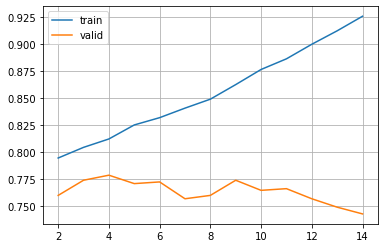

In [8]:
fig, ax = plt.subplots()
plt.plot(range(2,15), accuracy_train_list, axes=ax, label='train')
plt.plot(range(2,15), accuracy_valid_list, axes=ax, label='valid')
plt.grid()
ax.legend()
None

In [9]:
print('Глубина дерева решений:', tree_max_depth)
print('Accuracy =', tree_accuracy.round(4))

Глубина дерева решений: 4
Accuracy = 0.7788


Доля правильных ответов на валидационной выборке возросла и стала больше требуемых 75%. Оценим accuracy на обучающей выборке:

In [10]:
accuracy_score(target_train, tree_model.predict(features_train)).round(4)

0.8123

Регулировкой одного параметра удалось улучшить качество модели: увеличить точность и уменьшить переобученность.

In [11]:
# сохраним значения в словаре для будущего сравнения
accuracy_dict = {}
accuracy_dict['Дерево решений'] = [accuracy_score(target_train, tree_model.predict(features_train)), tree_accuracy]

<a id='forest'></a>
### Модель случайного леса

Модель случайного леса представляет собой набор деревьев решений. Для пробного раза позволим алгоритму обучиться в вольном стиле, используя все параметры по умолчанию:

In [12]:
forest_model = RandomForestClassifier(random_state=1)

forest_model.fit(features_train, target_train)
predictions_valid = forest_model.predict(features_valid)
forest_accuracy = accuracy_score(target_valid, predictions_valid)

print('Accuracy на валидационной выборке:', forest_accuracy.round(4))
print('Accuracy на обучающей выборке:', accuracy_score(target_train, forest_model.predict(features_train)).round(4))

Accuracy на валидационной выборке: 0.7913
Accuracy на обучающей выборке: 1.0


Хоть accuracy на валидационной выборке больше требуемых 75%, модель переобучена, поэтому необходимо провести дополнительную настройку. Ключевыми гиперпараметрами случайного леса являются максимальная глубина отдельного дерева  и количество деревьев. Перебором определим сочетание параметров, при котором точность предсказаний на валидационной выборке наибольшая:

In [13]:
forest_model = None
forest_accuracy = 0
forest_max_depth = 0

for depth in range(1,20):
    for n_est in range(2, 50):
        model = RandomForestClassifier(max_depth=depth, n_estimators=n_est, random_state=1)
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)
        accuracy = accuracy_score(target_valid, predictions_valid)
        if accuracy > forest_accuracy:
            forest_model, forest_accuracy, forest_max_depth, forest_n_est = model, accuracy, depth, n_est

print('max_depth =', forest_max_depth)
print('n_est =', forest_n_est)

print('Accuracy на валидационной выборке:', forest_accuracy.round(4))
print('Accuracy на обучающей выборке:', accuracy_score(target_train, forest_model.predict(features_train)).round(4))

accuracy_dict['Случайный лес'] = [accuracy_score(target_train, forest_model.predict(features_train)), forest_accuracy]

max_depth = 12
n_est = 25
Accuracy на валидационной выборке: 0.8037
Accuracy на обучающей выборке: 0.9129


<a id='forest_rs'></a>
Поиск оптимальных гиперпараметров перебором весьма ресурсоемкий даже для двух величин. В качестве альтернативы существует метод случайного поиска по гиперпараметрам. Хотя при таком поиске производится перебор не по всем возможным комбинациям, такой подход позволяет рассмотреть больше гиперпараметров для поиска оптимального сочетания. Рассмотрим следующие параметры:

- `n_estimators` - количество деревьев
- `max_depth` - наибольшая глубина дерева
- `min_samples_split` -  минимальное число объектов, необходимое для того, чтобы узел дерева мог бы расщепиться
- `min_samples_leaf` - минимальное число объектов в листьях.

In [14]:
param_distr = {
    'n_estimators': list(range(2,100, 2)),
    'max_depth': [None] + list(range(2,20)),
    'min_samples_split': list(range(2,11)),
    'min_samples_leaf': list(range(1,11))  
}

# <случайный лес к которому будем подбирать параметры>
forest_model_search = RandomForestClassifier(random_state=1)

# <модель>
forest_model_search = RandomizedSearchCV(forest_model_search, param_distr, random_state=1)

# <обучаем модель> 
forest_model_search.fit(features_train, target_train)
None

In [15]:
forest_model_search.best_params_

{'n_estimators': 88,
 'min_samples_split': 3,
 'min_samples_leaf': 7,
 'max_depth': 18}

In [16]:
accuracy_dict['Случайный лес(RandomizedSearch)'] = [accuracy_score(target_train, forest_model_search.predict(features_train)), 
                                  accuracy_score(target_valid, forest_model_search.predict(features_valid))]

print('Accuracy на валидационной выборке:', accuracy_dict['Случайный лес'][1].round(4))
print('Accuracy на обучающей выборке:', accuracy_dict['Случайный лес'][0].round(4))

Accuracy на валидационной выборке: 0.8037
Accuracy на обучающей выборке: 0.9129


Точность на валидационной выборке меньше, чем  ранее, но разница между точностью на обучающей и валидационной выборках заметно уменьшилась. Проверим обе модели на тестовой выборке.

<a id='lr'></a>
### Модель логистической регрессии

Модель логистической регресии не использует дерево решений. Алгоритм создает линейное выражение, в котором при обучении подбирает коэффициенты при каждом независимом входном параметре - коэффициенты регрессии. Принципиально иной алгоритм может лучше подходить для описания данных.

In [17]:
lr_model = LogisticRegression(random_state=1, solver='liblinear', penalty='l1', C=2)

lr_model.fit(features_train, target_train)
predictions_valid = lr_model.predict(features_valid)
lr_accuracy = accuracy_score(target_valid, predictions_valid)

In [18]:
accuracy_dict['Логистическая регрессия'] = [accuracy_score(target_train, lr_model.predict(features_train)), 
                                  accuracy_score(target_valid, lr_model.predict(features_valid))]

print('Accuracy на валидационной выборке:', accuracy_score(target_valid, lr_model.predict(features_valid)).round(4))
print('Accuracy на обучающей выборке:', accuracy_score(target_train, lr_model.predict(features_train)).round(4))

Accuracy на валидационной выборке: 0.729
Accuracy на обучающей выборке: 0.7512


Модель имеет мало возможностей для улучшения. 73% - наибольшее значение точности, которое удалось получить. 

<a id='summary_research'></a>
### Вывод

На данном этапе были выбраны несколько моделей, для которых на основе обучаещей и валидационной выборок были определены некоторые гиперпараметры, чтобы улучшить качество предсказаний. Ниже представлена таблица со значениями accuracy для каждой модели:

In [19]:
pd.options.display.float_format = '{:,.3f}'.format #dataframe output formatting

pd.DataFrame(accuracy_dict.values(), index=accuracy_dict.keys(),
             columns=['Обучающая выборка','Валидационная выборка'])

,Обучающая выборка,Валидационная выборка
Дерево решений,0.812,0.779
Случайный лес,0.913,0.804
Случайный лес(RandomizedSearch),0.855,0.794
Логистическая регрессия,0.751,0.729


Минимальное требуемое значение accuracy - 75%. Модель логистической регрессии не удовлетворяет этому требованию на валидационной выборке, поэтому необходимо ее исключить.

В качестве рабочей модели для проверки на тестовой выборке оставляем модель случайного леса с 4 заданными гиперпараметрами:
    
- `n_estimators` = 88
- `min_samples_split` = 3
- `min_samples_leaf` = 7
- `max_depth` = 18

<a id='sec_4'></a>
## Проверьте модель на тестовой выборке

In [20]:
predictions = forest_model_search.predict(features_test)
accuracy_score(target_test, predictions).round(2)

0.82

Выбранная модель удовлетворяет требованиям.

<a id='sec_5'></a>
## Проверьте модели на адекватность

Сравним рабочую модель с  "бросанием монетки" - тариф рекомендуется случайным образом:

In [21]:
random_predictions = np.random.choice(np.arange(2), size=len(target_test))

accuracy_random = accuracy_score(target_test, random_predictions)

print('accuracy =', accuracy_random.round(4))

accuracy = 0.5023


Модель бросания монетки можно усовершенствовать. В исходных данных абонентов с тарифом "Ультра" меньше, чем с тарифом "Смарт": 

In [22]:
p_ultra = target_test.sum()/len(target_test)
p_ultra.round(2)

0.33

Учтем этот факт при распределении вероятности:

In [23]:
random_predictions = np.random.choice(np.arange(2), p=[1-p_ultra, p_ultra], size=len(target_test))

accuracy_random = accuracy_score(target_test, random_predictions)

print('accuracy =', accuracy_random.round(2))

accuracy = 0.57


Точность новой "монетки" уже выше, чем ранее, но все же она сильно ниже, чем у рабочей модели.

Если предлагать всем по умолчанию тариф "Смарт", то точность окажется 1 - 0.3266 = 0.6734, но этот показатель все еще ощутимо ниже, чем при расчетах рабочей модели.

Посмотрим, отражают ли предсказания модели действительность. Например, модель может предвзято выбирать тариф "Смарт", так как он чаще встречается. Можно узнать долю абонентов "Ультра" в предсказаниях по тестовой выборке:

In [24]:
(predictions.sum()/len(predictions)).round(2)

0.23

Проведем еще один эксперимент. Передадим рабочей модели тестовые данные только от абонетов с тарифом "Смарт":

In [25]:
features_smart = features_test[target_test == 0]
target_smart = target_test[target_test == 0]
accuracy_score(target_smart, forest_model_search.predict(features_smart)).round(2)

0.93

Аналогично с тарифом "Ультра":

In [26]:
features_ultra = features_test[target_test == 1]
target_ultra = target_test[target_test == 1]
accuracy_score(target_ultra, forest_model_search.predict(features_ultra)).round(2)

0.58

Модель действительно чаще выбирает тариф "Смарт": и доля "Ультра" в предсказаниях ниже, чем в реальности, и accuracy для данных тарифа "Смарт" более 90%, в то время как для "Ультра" правильных ответов чуть больше половины.

<a id='summary_5'></a>
### Выводы

На данном этапе проведен анализ адекватности модели. Точность предсказаний сравнена с точностью при со случайном выборе тарифа и при выборе по умолчанию. Рабочая модель демонстрирует более высокое качество, что говорит в пользу ее адекватности. 

Дополнительно были рассмотрены особенности точности предсказаний в зависимости от входных данных: рассмотрены отдельно предсказания для тарифов "Смарт" и "Ультра". Модель показывает смещение в сторону тарифа "Смарт": и доля "Ультра" в предсказаниях ниже, чем в реальности, и accuracy для данных тарифа "Смарт" более 90%, в то время как для "Ультра" правильных ответов чуть больше половины. 

Однако не стоит признавать модель некорректной. На мой взгляд, причина может быть в особенностях данных. Во-первых, 1 месяц активности не является репрезентативным. Пользователь мог отклонится от своих обычных показателей: в отпуске можно тратить меньше минут из-за отсутствия рабочих звонков или, наоборот, потребуется совершить больше звонков в командировке. Во-вторых, стоит учесть человеческий фактор. Абонент при выборе тарифа мог ошибиться и выбрать не самый выгодный для себя тариф. В целом, конечно, необходимо более подробно изучить эту особенность.

<a id='summary'></a>
## Выводы

В нашем распоряжении были данные о поведении клиентов, которые уже перешли на исследуемые тарифы "Смарт" и "Ультра". Необходимо было построить модель для задачи классификации. Основным требованием было значение accuracy на тестовой выборке не менее 75%.

Данные были разделены на три выборки: обучающую, валидационную и тестовую. В качестве возможных моделей рассмотрены модели решающего дерева, случайного леса и логистической регрессии. Для каждой из них на основе обучаещей и валидационной выборок были определены некоторые гиперпараметры, чтобы улучшить качество предсказаний.

В качестве рабочей модели принята модели случайного леса с 4 заданными параметрами. На тестовой выборке точность составила 82%. 
А
декватность модели оценена путем сравнения точности предсказаний рабочей модели, модели случайного выбора тарифа и выбора по умолчанию. Рабочая модель демонстрирует большую долю правильных ответов.

Дополнительно были рассмотрены особенности точности предсказаний в зависимости от входных данных. Модель "предпочитает" выбирать тариф "Смарт": почти половине абонентов "Ультра" рекомендуется "Смарт", и в целом доля рекомендаций тарифа "Ультра" ниже.